In [1]:
##### Import Pacakges
import pandas as pd
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import os
from IPython.display import Image
import sklearn
from sklearn import tree
import math
#from dstools import data_tools

import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 10

In [2]:
data_dept = pd.DataFrame.from_csv('processed_data.csv')
#Set X and Y
X = data_dept.drop('Target_Variable',1)
Y = data_dept['Target_Variable']
#Create Date Splits
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, train_size =.75)

In [ ]:
#Information Gain Feature Selection
def entropy(target):
    '''
        Computes the entropy for a set of instances (that's needed is the values of the target variable)
        Presumes the target values are class indexes -- integers
        Thus, target is an array of integers
    '''
    # Get the number of instances
    n = len(target)
    # Count how frequently each unique target value occurs using the numpy function 
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    
    # Otherwise, for each possible value, update entropy; use zero for 0 log 0
    for count in counts:
        if count == 0:
            entropy += 0
        else:
            entropy += math.log(count/n, 2) * count/n
    # Return entropy
    return -1 * entropy


def information_gain(feature, threshold, target):
    '''
    This function takes three things:
    feature - A list of all the values this feature takes on, in some instance order, e.g. data['revenue']
    threshold - A number at which to threshold a continuous variable, e.g. 1.2
    target - A list of all the target values, in the same order as feature, e.g. data['churndep']
    '''
    # Using numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Record if each feature value is above the threshold
    feature = (feature <= threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For each side of the threshold, update the information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig


def best_threshold(X, Y):
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X:
        ig = information_gain(X, threshold, Y)
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return maximum_threshold 


Y2 = Y.astype(int)


features = []
igs = []

for feature in X.columns:
    features.append(feature)
    threshold = best_threshold(X[feature], Y2)
    igs.append( information_gain(X[feature], threshold, Y2) )

# Use the lists we created to plot

plt.bar(range(len(features)), igs)
plt.xticks(range(len(features)), features, rotation=70)
plt.show()


In [5]:
#Test Initial Decision Tree Classifer
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,Y_train)
print('baseline model: %.4f' % metrics.accuracy_score(Y_test,dt_model.predict(X_test))) #0.702

baseline model: 0.7023


In [ ]:
# Tune DT by finding the best parameters with grid search


min_samples_leaf= [1,3,5,10,20, 50, 75, 100]
max_depth_list = [1,2,3,4,5,6,7,8,9,10]

num_splits_list = []

for i in range(1,20):
    num_splits = np.power(2, i)
    num_splits_list.append(num_splits)


grid_tree = {'min_samples_split': num_splits_list, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth_list}
    
Tree_model = DecisionTreeClassifier(criterion="entropy")
Tree_model_clf = GridSearchCV(Tree_model, grid_tree)
Tree_model_clf.fit(X,Y)

print(Tree_model_clf.best_estimator_.min_samples_split)
print(Tree_model_clf.best_estimator_.min_samples_leaf)
print(Tree_model_clf.best_estimator_.max_depth)
#max_depth=10, min_samples_leaf = 5, min_samples_split = 32

In [ ]:
#Tuned DT
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 5, min_samples_split = 32)
dt_model.fit(X_train,Y_train)
metrics.accuracy_score(Y_test,dt_model.predict(X_test))


In [38]:
#Cross Val DT
print(np.mean(cross_val_score(dt_model, X, Y,cv=5)))
print(np.mean(cross_val_score(dt_model, X, Y, cv=5, scoring ="roc_auc")))

0.59308127958412649

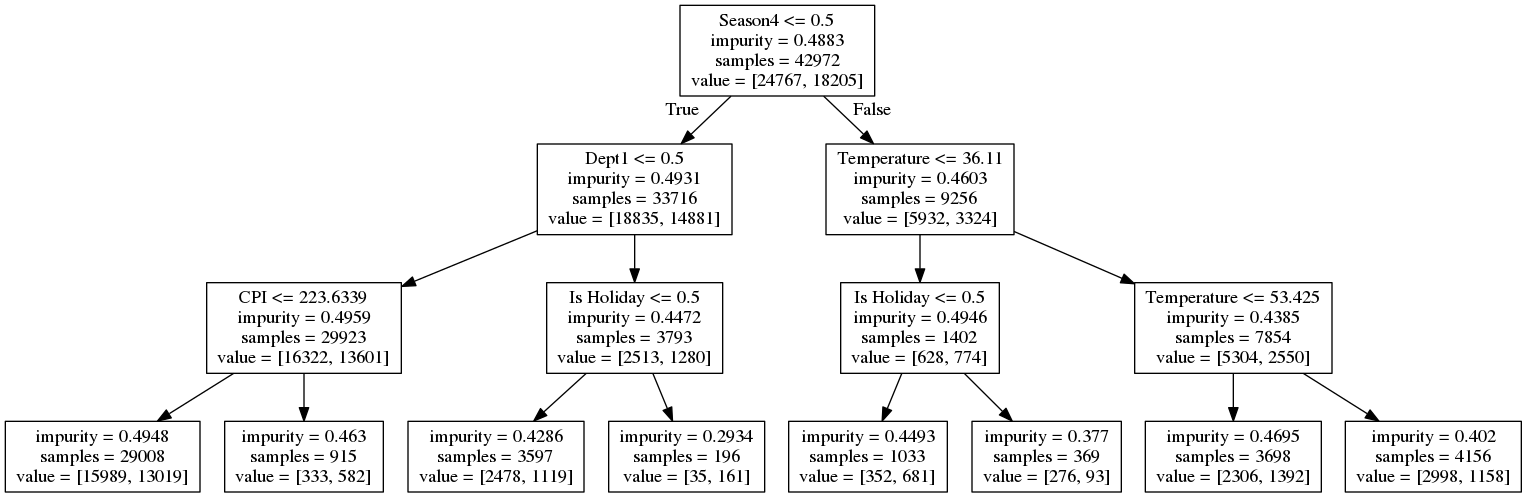

In [16]:
# A function that gives a visual representation of the decision tree
def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    
    # Export our decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    
    # Call graphviz to make an image file from our decision tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')



Decision_Tree_Image(dt_model, X.columns)


In [ ]:
# Opitmal cross validation Folds - Roc

cv_number_folds = [2,3,5,7,10]

# Decision tree cross-validation auc
dt_all_auc = []
dt_all_std = []

for folds_count in cv_number_folds:
    dt_all_auc.append(np.mean(cross_val_score(dt_model, X, Y, cv=folds_count, scoring ="roc_auc"))) 
    dt_all_std.append(np.std(cross_val_score(dt_model, X, Y,cv=folds_count, scoring ="roc_auc")))

plt.errorbar( cv_number_folds, dt_all_auc, label="Decision Tree AUC score", yerr = dt_all_std)

plt.xlabel("Folds")
plt.ylabel("AUC Score")
plt.legend()
plt.show()

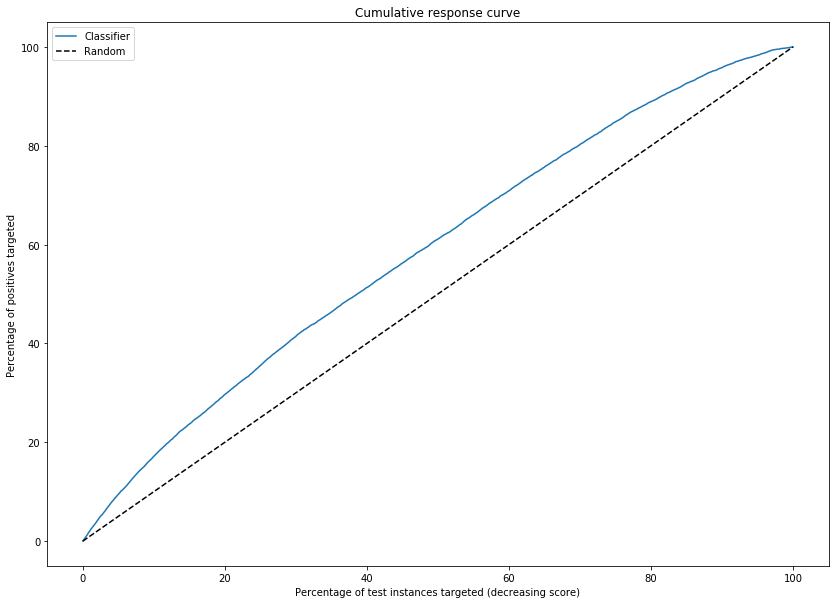

In [35]:
#Cumulative response curve DT


# Fit a logistic regression model

dt_model.fit(X_train, Y_train)

# Get the predicted value and the probability of Y_test records being = 1
Y_test_predicted = dt_model.predict(X_test)
Y_test_probability_1 = dt_model.predict_proba(X_test)[:, 1]

# Sort these predictions, probabilities, and the true value in descending order of probability
order = np.argsort(Y_test_probability_1)[::-1]
Y_test_predicted_sorted = Y_test_predicted[order]
Y_test_probability_1_sorted = Y_test_probability_1[order]
Y_test_sorted = np.array(Y_test)[order]

# Go record-by-record and build the cumulative response curve
x_cumulative = []
y_cumulative = []
total_test_positives = np.sum(Y_test)
for i in range(1, len(Y_test_probability_1_sorted)+1):
    x_cumulative.append(i)
    y_cumulative.append(np.sum(Y_test_sorted[0:i]) / float(total_test_positives))

# Rescale
x_cumulative = np.array(x_cumulative)/float(np.max(x_cumulative)) * 100
y_cumulative = np.array(y_cumulative) * 100

# Plot
plt.plot(x_cumulative, y_cumulative, label="Classifier")
plt.plot([0,100], [0,100], 'k--', label="Random")
plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Cumulative response curve")
plt.legend()

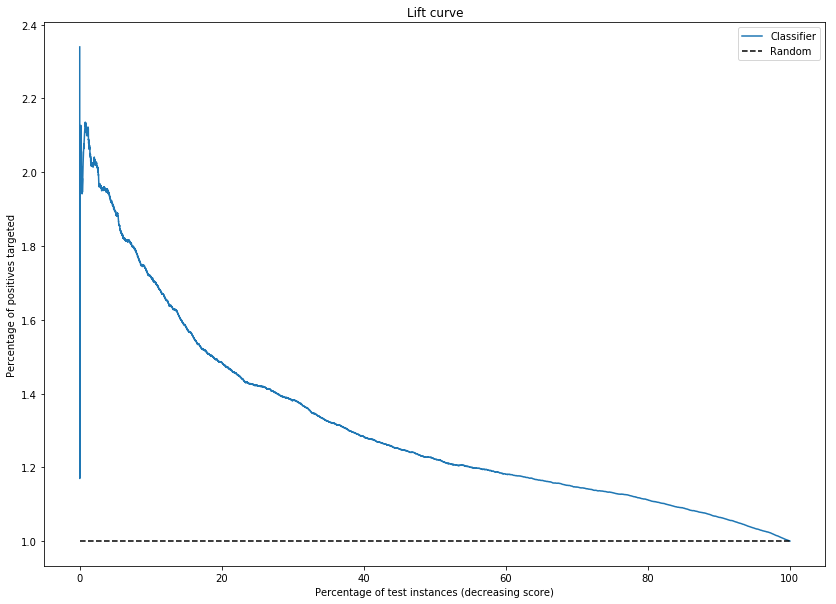

In [36]:
#Lift Curve
x_lift = x_cumulative
y_lift = y_cumulative/x_lift

plt.plot(x_lift, y_lift, label="Classifier")
plt.plot([0,100], [1,1], 'k--', label="Random")
plt.xlabel("Percentage of test instances (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Lift curve")
plt.legend()
plt.show()